# T1
### Exercise 3

In this exercise we take a look at an *in-vivo* FLASH acquisition using two flip angles and a B1 (flip angle "efficiency") estimate.

In [2]:
# import packages
import numpy as np
import nibabel as nib
import pathlib as plb
import matplotlib.pyplot as plt
import tqdm

plt.style.use('ggplot')

# set up data path
data_path = plb.Path().resolve().parents[1].absolute().joinpath("data/")
p_pdw = data_path.joinpath("PDw.nii")
p_t1w = data_path.joinpath("T1w.nii")
p_b1 = data_path.joinpath("B1map.nii")

We know the flip angles used in the acquisition (6° for pd weighting, 21° for T1w -> to see the connection to the contrast weighting refer to the last exercise plots of T1 against the flip angle alpha). The B1 map gives an estimate for how exact the flip angles are attained in the measurement.

In [3]:
# set fa
alphas = np.array([6, 21])
alphas = np.radians(alphas)

# load in data
d_b1 = nib.load(p_b1)
d_t1w = nib.load(p_t1w)
d_pdw = nib.load(p_pdw)
# save affine for later
aff = d_t1w.affine
# caution B1 [%] is scaled

We could in principle use numpy and matrix multiplication to calculate the whole volume straigt away. However, from allocation considerations and the scaling of the calculations it makes sense to define it per slice
(a %%timeit for the full volume fit gave 27.8 s ± 756 ms per loop (mean ± std. dev. of 7 runs, 1 loop each, execution time)

In [125]:
# define fit function per slice (whole volume might run into allocation trouble)
def fit_slice_t1(alpha1_data_slice, alpha2_data_slice, alpha1, alpha2, b1_eff: np.ndarray = None):
    if b1_eff is None:
        b1_eff = np.ones_like(alpha1_data_slice)
    X = np.ones((*alpha1_data_slice.shape, 2, 2))
    y = np.ones((*alpha1_data_slice.shape, 2))
    # assign data
    X[:, :, 0, 1] = np.divide(
        alpha1_data_slice, np.tan(alpha1 * b1_eff),
        where=np.tan(alpha1 * b1_eff)>np.finfo(float).eps,
        out=np.zeros_like(b1_eff)
    )
    X[:, :, 1, 1] = np.divide(
        alpha2_data_slice, np.tan(alpha2 * b1_eff),
        where=np.tan(alpha2 * b1_eff)>np.finfo(float).eps,
        out=np.zeros_like(b1_eff)
    )

    y[:, :, 0] = np.divide(
        alpha1_data_slice, np.sin(alpha1 * b1_eff),
        where=np.sin(alpha1 * b1_eff)>np.finfo(float).eps,
        out=np.zeros_like(b1_eff)
    )
    y[:, :, 1] = np.divide(
        alpha2_data_slice, np.sin(alpha2 * b1_eff),
        where=np.tan(alpha2 * b1_eff)>np.finfo(float).eps,
        out=np.zeros_like(b1_eff)
    )

    # find idx with enough snr
    idx_to_compute = (alpha1_data_slice > thresh) & (alpha2_data_slice > thresh) & (b1_eff > 0.3)
    B = np.zeros_like(X)
    beta = np.zeros_like(alpha1_data_slice)
    B[idx_to_compute] = np.matmul(np.swapaxes(X[idx_to_compute], 1, 2), X[idx_to_compute])
    B[idx_to_compute] = np.linalg.inv(B[idx_to_compute])
    B[idx_to_compute] = np.matmul(B[idx_to_compute], np.swapaxes(X[idx_to_compute], 1, 2))
    beta[idx_to_compute] = np.matmul(
        B[idx_to_compute], y.reshape((*y.shape, 1))[idx_to_compute]
    )[:,0,0]
    return beta


In [134]:
# create array for quantitative values
q_t1 = np.zeros(d_t1w.shape)
q_t1_corr = np.zeros(d_t1w.shape)
# define signal threshold for calculating T1 (based on 800um 3T example data)
thresh = 60.0
# fit
for slice_idx in tqdm.trange(d_pdw.shape[2], desc='processing slices'):
    # load in data per slice corresponding to fa (alpha1 -> pdw, alpha2 -> t1w)
    slice_d_pdw = np.squeeze(
        np.nan_to_num(d_pdw.slicer[:,:,slice_idx:slice_idx+1].get_fdata())
    )
    slice_d_t1w = np.squeeze(
        np.nan_to_num(d_t1w.slicer[:,:,slice_idx:slice_idx+1].get_fdata())
    )
    # load in b1 data for the corrected fit - cast from %
    slice_b1 = np.squeeze(
        np.nan_to_num(d_b1.slicer[:,:,slice_idx:slice_idx+1].get_fdata())
    ) / 100.0

    q_t1[:,:,slice_idx] = fit_slice_t1(
        slice_d_pdw, slice_d_t1w, *alphas
    )
    q_t1_corr[:,:,slice_idx] = fit_slice_t1(
        slice_d_pdw, slice_d_t1w, *alphas,
        b1_eff=slice_b1)


processing slices: 100%|██████████| 208/208 [00:22<00:00,  9.33it/s]


In [135]:
# save as niftii
t1_img = nib.Nifti1Image(q_t1, affine=aff)
nib.save(t1_img, data_path.joinpath("estimated_qt1.nii"))

t1_img = nib.Nifti1Image(q_t1_corr, affine=aff)
nib.save(t1_img, data_path.joinpath("estimated_qt1_b1-corrected.nii"))

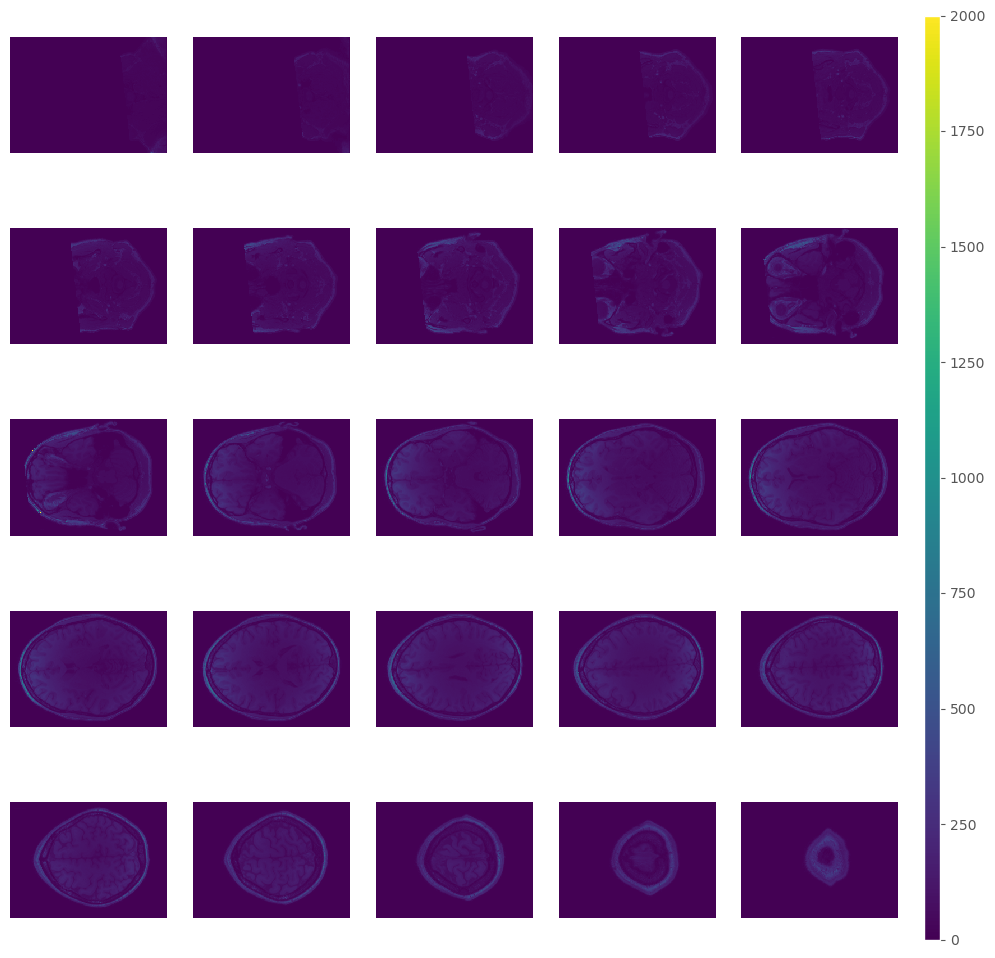

In [163]:
# dim = 1
# fig = plt.figure(figsize=(12,12))
# gs_big = fig.add_gridspec(5,6, width_ratios = [10,10,10,10,10,1])
# multi = int(q_t1.shape[dim] * 4 / 5 / 25)
#
# sli_num = int(q_t1.shape[dim] / 7) + np.arange(25) * multi
# for plot_row in range(5):
#     for plot_column in range(5):
#         ax = fig.add_subplot(gs_big[plot_row, plot_column])
#         img = ax.imshow(np.flipud(q_t1[:,sli_num[plot_row*5+plot_column],:].T), interpolation='None', cmap='viridis', clim=(0,2000))
#         ax.grid(False)
#         ax.axis(False)
# ax_cb = fig.add_subplot(gs_big[:,-1])
# plt.colorbar(img, cax=ax_cb)
# plt.show()